# Part 1 - Linkedin Web Scraper

**Web Scraper for sales positions in the US**

Note:
The first part of the code (extracting the basic info for every job post might take about 8 minutes)
The second part (applying job description to every row using threads and threadspool in several iterations) might take about 30 minutes - depends on the number of iterations you coose to apply (about 4 minutes per iteration, but it should decrease from iteration to iteration)

If your final NotFound file is too big please check:
  - are your delimiters catching the html?
  - did you define enough iterations? each iteration might only catch about 10% of the job description due to requests limitations
  - you can always copy the job description function to another block, and run only that on a failed case

In [ ]:
# Imports & Installs
!pip install requests
import re
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import time
import random
import concurrent.futures
from google.colab import files
import threading
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
positions = ['sales', 'sales development representative','sdr', 'business development representative',
             'bdr','seller', 'salesperson', 'sales development representative']
key_words_to_remove = ['manager', 'president','supervisor','director', 'vp']

In [ ]:
def get_linkedin_url(job_title, page_start_index):
  '''
  Create basic Linkedin search page link.
  Assigning different index allows to flip over search pages
  '''
  base_url = 'https://www.linkedin.com/jobs/search/?currentJobId=3560984198&geoId=103644278&keywords={}&location=United%20States&refresh=true&start={}'
  base_url = base_url.format(job_title.replace(' ', '%20'), page_start_index)
  return base_url

#######################################################################################################

def find_JobTitleLocation_split(URL):
  '''
  This function gets an URL input of Linkedin search page as string and returns
  a data frame of this pages results (25 results per page), with basic info:
  Position (name), Company (name), Location, Link (to every position Linkedin page)
  '''
  response = requests.get(URL)
  text = response.text

  title_start_delim = '<h3 class="base-search-card__title">'
  title_end_delim = '</h3>'
  location_start_delim = '<span class="job-search-card__location">'
  location_end_delim = '</span>'
  company_start_delim = 'job-search-card-subtitle">'
  company_end_delim = '</a>'
  link_start_delim = '<a class="base-card__full-link absolute top-0 right-0 bottom-0 left-0 p-0 z-[2]" href="'
  link_end_delim = 'data-tracking-control-name='

  links = []
  positions = []
  locations = []
  companies = []
  #descriptions = []
  start_index = 0
  while True:
      start_index = text.find(link_start_delim, start_index)
      if start_index == -1:
          break
      end_index = text.find(link_end_delim, start_index)
      link = text[start_index + len(link_start_delim):end_index].strip()
      links.append(link[:-1])

      position_start_index = text.find(title_start_delim, end_index)
      position_end_index = text.find(title_end_delim, position_start_index)
      position = text[position_start_index + len(title_start_delim):position_end_index].strip()
      positions.append(position)

      location_start_index = text.find(location_start_delim, end_index)
      location_end_index = text.find(location_end_delim, location_start_index)
      location = text[location_start_index + len(location_start_delim):location_end_index].strip()
      locations.append(location)

      company_start_index = text.find(company_start_delim, end_index)
      company_end_index = text.find(company_end_delim, company_start_index)
      company = text[company_start_index + len(company_start_delim):company_end_index].strip()
      companies.append(company)
      start_index = end_index

  df = pd.DataFrame({'Position': positions,'Company': companies,'Location': locations,'Link':links})

  return df

#######################################################################################################

def get_job_description(job_post_URL):
  '''
  The most basic job description finder in the html. Gets the link to the job 
  post (position page on Linkedin), and returns the description (un-parsed)
  '''
  # have a list of common start and end delims for descriptions, use them by similar index
  start_delims = ['"description":','class="description__text description__text--rich">']
  end_delims = [',"employmentType":','<button class=']
  # In some cases description was not found even tough get_job_description finds one.
  # This might happen because too many requests were made in a short period of time
  # Add sleep function to try and pass that properly
  # In the future I can try to do another QA on that...
  time.sleep(random.uniform(0.5,1.5))
  response = requests.get(job_post_URL)
  text = response.text

  # I found that different job postings have different delimiters so I'll try to catch as many as I can
  # by exploring the "Description not found" list
  for index in range(len(start_delims)):
    start_delim = start_delims[index] 
    end_delim =  end_delims[index]
    start_index = 0
    start_index = text.find(start_delim, start_index)
    if start_index == -1:
      continue # These delims didn't catch the description
    else:
      end_index = text.find(end_delim, start_index)
      description = text[start_index + len(start_delim):end_index].strip()
      return description
  return 'Description not found'  

#######################################################################################################

# define function to clean html tags and get the cleaned text out of the description
def clean_html_tags(text):
  '''
  Cleans the job description from the html tags messing it up. Activated on the 
  description extracted from get_job_description(job_post_URL)
  '''
  soup = BeautifulSoup(text, 'html.parser')
  text = soup.get_text()
  soup = BeautifulSoup(text, 'html.parser')
  return soup.get_text()

#######################################################################################################

def apply_threadpool_executor(df,res_list):
  '''
  Apply threadpool executor in order to execute the request for description more efficiently.
  input data frame is a segment of the extracted data frame from the function
  GetJobsInfo(positions,key_words_to_remove). This function allows faster job description extraction
  on a single data frame.
  When finished, send the result data frame to a list external to the threads to be concated
  '''
  # Apply description only after having the final data frame (running time)
  # get description using threadpool
  with concurrent.futures.ThreadPoolExecutor() as executor:
      res = list(executor.map(get_job_description, df['Link']))
  df['Description'] = res

  # Result data frame is ready, clean it up and send it out
  # apply function to column of dataframe to clean it from undesired tags
  df['Description'] = df['Description'].apply(clean_html_tags)
  res_list.append(df)

#######################################################################################################

def ApplyJobDescription_Parallel(df,scraping_results):
  '''
  Input: A description-less data frame
  Function splits input to 7 data sets (= number of CPU's in my computer)
  Than, by using 7 threads, activate apply_threadpool_executor on every part that will use
  thread pool in order to speed the extraction of the job description to this part.
  Appendes the results together to a single df.
  Split the df to sucess (concat to current results) and to notfound which will be passed again to the loop
  Loop runs for 50 times max to catch as many descriptions as possible.
  An overload of requests in a single loop results in missing descriptions, thus the repeated loop on
  the same data set.
  '''
  # Assign big not_found_size value for the first loop
  not_found_size = math.inf

  for iter in range(50):
    # Change loop to run for about 10-20 iterations
    # -> the more iterations you set the more descriptions you'll get
    print(f'Iteration number: {iter}')
    res_list = []
    threads = []
    # Split input to max 7 datasets for parallel work
    df_list = np.array_split(df, min(7,df.shape[0]))
    for i in range(len(df_list)):
        t = threading.Thread(target=apply_threadpool_executor, args=(df_list[i],res_list))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    # finished this iteration extraction, devide to sucess and failure
    res = pd.concat(res_list)
    not_found = res[res['Description'] == 'Description not found']
    res = res.drop(not_found.index)
    res = res.reset_index(drop=True) 
    scraping_results = pd.concat([scraping_results,res])

    # If the size of the data frame doesn't change much from last iteration -> finish task
    # Set diff to be 50 records minimum or abort task
    diff = not_found_size - not_found.shape[0]
    if not_found.empty:
      return scraping_results, "I finished my job, Mom!"
    elif diff < 50:
      return scraping_results , not_found
    else:
      df = not_found
      not_found_size = not_found.shape[0]

  # If all the loops are finished:
  return scraping_results , not_found

#######################################################################################################

def GetJobsInfo(positions,key_words_to_remove):
  '''
  This is the main function that activates all the rest.
  Insert a list of positions in non-capital letters to search in the USA.
  Each page will show the first 25 results, so create an innerloop to pass through pages for every position.
  After the creation of the initial data set, function will activate the extraction of job descriptions.
  This function will download 4 files based on it's progress (for QA and for
  the option to get results even for incomplete execution - see section below)
  '''
  res = []
  start_index = 0
  for job_title in positions:
    for page_number in range(40): #scan the first 100 pages for every position, If exists
      URL = get_linkedin_url(job_title,start_index)
      try:
        tmp = find_JobTitleLocation_split(URL)
        # Run untill you get empty results from the function
        # Do not concatenate empty data frames
        # Sleep a little before going into the next page
        if tmp.empty:  
          break
        else:
          res.append(tmp)
          start_index += 25
          time.sleep(random.uniform(0.8,1.6))

      except Exception as e:
        print(f'Exception in job title {job_title}')
        continue

  # Concat all the data frames together
  # Reset index to allow deletion by index
  res = pd.concat(res).drop_duplicates()
  res.to_excel('RawResults_forTest_noDescription.xlsx', index=True)
  files.download('/content/RawResults_forTest_noDescription.xlsx')

  # remove unwanted positions using the keywords above
  removed = res.loc[res['Position'].str.contains('|'.join(key_words_to_remove), case=False)]
  res = res.drop(removed.index)
  res = res.reset_index(drop=True)
  res.to_excel('RawResults_forTest_noDescription_filtered.xlsx', index=True)
  files.download('/content/RawResults_forTest_noDescription_filtered.xlsx')

  print(f'Primary results file created and downloaded, next step: apply job descriptions')

  # res parameter holds the exported initial data
  # create empty final data frame for concatination of sub result data frames.
  scraping_results = pd.DataFrame({'Position': [],'Company': [],'Location': [],'Link':[],'Description': []})

  # Function activation (job titles extraction), export 2 final files after all threads are completed
  scraping_results, not_found = ApplyJobDescription_Parallel(res,scraping_results)

  scraping_results.to_excel('ScrapingResults.xlsx', index=True)
  files.download('/content/ScrapingResults.xlsx')
  if isinstance(not_found,str):
    print(not_found)
  else:
    not_found.to_excel('NotFound.xlsx', index=True)
    files.download('/content/NotFound.xlsx')


In [ ]:
res = GetJobsInfo(positions,key_words_to_remove)

The next part uses functions from the main scraper but allows you to scrape only for the job descriptions assuming you already have position name, company, location, link in a data frame.
You can import a file of your choice and run this block.

If not used, keep hidden to not overrun the main function, that will be sad...

In [ ]:
# jobs_data = pd.read_excel('/content/RawResults_forTest_noDescription_filtered.xlsx')
# scraping_results = pd.DataFrame({'Position': [],'Company': [],'Location': [],'Link':[],'Description': []})

# # Function activation, export 2 files
# scraping_results, not_found = ApplyJobDescription_Parallel(jobs_data,scraping_results)

# scraping_results.to_excel('ScrapingResults.xlsx', index=True)
# files.download('/content/ScrapingResults.xlsx')
# if isinstance(not_found,str):
#   print(not_found)
# else:
#   not_found.to_excel('NotFound.xlsx', index=True)
#   files.download('/content/NotFound.xlsx')

Test: can't the job description be found? or is it a request issue?

In [ ]:
# If a text description is returned, the delimiters are set properly and it's a request issue
# ...(you can try re-run the supportive function above onthe remaining input)


# link_ex = 'https://www.linkedin.com/jobs/view/dealer-21-at-boyd-gaming-3606416722?refId=GM5hsc6B1nErRb%2F0tfRVJA%3D%3D&amp;trackingId=sKhMYv7jCoK2fPfkzx9GKA%3D%3D&amp;position=15&amp;pageNum=0&amp;trk=public_jobs_jserp-result_search-card'
# get_job_description(link_ex)

'"&lt;strong&gt;&lt;u&gt;Position Description&lt;br&gt;&lt;br&gt;&lt;/u&gt;&lt;/strong&gt;Deal assigned games in an accurate manner while providing outstanding customer service.&lt;br&gt;&lt;br&gt;Job Functions&lt;br&gt;&lt;ul&gt;&lt;li&gt;Deal game according to standard rules, company procedures, and applicable gaming regulations.&lt;/li&gt;&lt;li&gt;Shuffle and deal cards accurately to customers.&lt;/li&gt;&lt;li&gt;Quickly and accurately calculate face value of cards.&lt;/li&gt;&lt;li&gt;Exchange cash for proper denominations of chips.&lt;/li&gt;&lt;li&gt;Pick up losing bets and cards from customer’s betting square. Pay winning bets and place chips in appropriate betting square.&lt;/li&gt;&lt;li&gt;Complete any required forms, records, and documents.&lt;br&gt;&lt;/li&gt;&lt;/ul&gt;&lt;strong&gt;&lt;u&gt;Position Requirements&lt;br&gt;&lt;br&gt;&lt;/u&gt;&lt;/strong&gt;Job Specifications&lt;br&gt;&lt;ul&gt;&lt;li&gt;Must be at least 21 years of age.&lt;/li&gt;&lt;li&gt;Six (6) months

# Part 2 - NLP Based Analysis of the Scraping Results

Before going to the next part I glimpsed over the results and removed in pandas duplicates in concatenated "Position-Company-Location", that resulted in 400 unique records, In order to save processing time and API calls

This part might take a while (up to 45 minutes for 400 filtered job descriptions)  as it involves many requests to OpenAI servers and no multy threading is implemented. Stay tuned, the fun starts here!

Be careful with the amounts of requests passed here. 1 full run over this 400 results costed somewhere between 5 to 10 US DOLLARS

In [ ]:
scraping_results = pd.read_excel('/content/ScrapingResults.xlsx')

# Assuming you have a DataFrame called 'scraping_results'
scraping_results = scraping_results.drop_duplicates(subset=['Position', 'Company', 'Location'])

# Print the deduplicated DataFrame
print(len(scraping_results))
scraping_results.head()

400


,Position,Company,Location,Link,Description
0,"Account Executive, Business Development (Corpo...",Chicago Bulls,"Chicago, IL",https://www.linkedin.com/jobs/view/account-exe...,"""Position OverviewThe Chicago Bulls are seekin..."
1,"Account Executive, Merchant Partnerships",PerkSpot,"Chicago, IL",https://www.linkedin.com/jobs/view/account-exe...,"""PerkSpot is searching for a Account Executive..."
2,Account Executive,Unibuddy,"New York, NY",https://www.linkedin.com/jobs/view/account-exe...,"""About usWe’ve grown at an incredibly fast pac..."
3,Account Sales Representative,PHX Management Group,"Tempe, AZ",https://www.linkedin.com/jobs/view/account-sal...,"""Phx Management in the greater Phoenix area is..."
4,Alcohol Sales Representative,PepsiCo,"Maumelle, AR",https://www.linkedin.com/jobs/view/alcohol-sal...,"""PBNA $23.25PepsiCo recently announced plans t..."


In [ ]:
!pip install openai
import re
import nltk
import openai
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import time
from openai.error import RateLimitError, InvalidRequestError

# Download required NLTK packages
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Set up your OpenAI API key
openai.api_key = 'YOUR_API_KEY'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


A more generic attempt - close in on the relevant parts in the text and use NLTK library to extract nouns out of it. Create a word cloud

In [ ]:
def text_slice(job_description):
      # Define keywords to slice the text
    keywords = ['skills', 'qualifications', 'basic', 'must have', 'nice to have', 'you must be', 'you are', 'you should apply if']
    company_keywords = ['who we are', 'a little bit about', 'about us']
    
    # Find the starting index by searching for the first occurrence of a keyword (case-insensitive)
    start_index = len(job_description)
    for keyword in keywords:
        match = re.search(re.escape(keyword), job_description, re.IGNORECASE)
        if match and match.start() < start_index:
            start_index = match.start()

    # In order to catch the most accurate result, if no match is found -> return None
    if start_index == len(job_description):
      return None
            
    
    # Find the ending index by searching for the first occurrence of a company keyword (case-insensitive)
    end_index = len(job_description)
    for company_keyword in company_keywords:
        match = re.search(re.escape(company_keyword), job_description[start_index:], re.IGNORECASE)
        if match and match.start() < end_index:
          end_index = match.start()
    
    # Slice the text to include only the relevant part between the start and end indices
    sliced_text = job_description[start_index:end_index]

    return sliced_text

#######################################################################################################

def extract_skills_nltk(job_description):
  
  # Slice job description
  job_description = text_slice(job_description)

  if job_description is None:
    return None

  else:
    # Tokenize the sliced text into sentences
    sentences = nltk.sent_tokenize(job_description)
    
    # Extract the skills using part-of-speech tagging
    skills = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        tagged_words = nltk.pos_tag(words)
        for word, tag in tagged_words:
            if tag == 'NNP' or tag == 'NNPS':  # Proper nouns
                skills.append(word)
      
    return skills

#######################################################################################################
# Define the worker function for extracting skills

def extract_skills_worker(row):
    description = row[4]
    parsed_skills = extract_skills_nltk(description)
    if parsed_skills is not None:
        return parsed_skills
    return []


There are 7813 nouns in the list


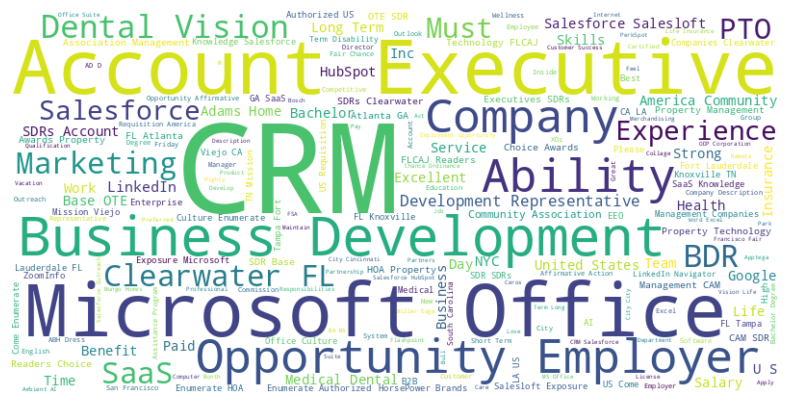

In [ ]:
# Use on all the descriptions from the scraped data set
# Iterate over the "Description" column in the DataFrame
# Create a thread pool
with ThreadPoolExecutor() as executor:
    # Iterate over the "Description" column in the DataFrame using the thread pool
    results = executor.map(extract_skills_worker, scraping_results.itertuples(index=False, name=None))

    # Collect the non-None results
    nouns_list = []
    for res in results:
        if res is not None:
            nouns_list += res

#################################################################

print(f'There are {len(nouns_list)} nouns in the list')

# Convert the list of nouns into a string separated by spaces
text = ' '.join(nouns_list)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can identify a few skills common for these positions, but nothing too obvious.

A more accurate attempt using OpenAI API
Note that this module is pricey, so carefully define your tests and the number of records you use.



In [ ]:
def set_prompt(job_description):
  '''
  Create basic Linkedin search page link.
  Assigning different index allows to flip over search pages
  '''
  prompt = '''Parse the skills from this sliced job description.
   Return a list of relevant skills or '' if failed to parse any.
   Delete any bullet point symbols such as '*' or '-' from the skills.
   Return the list as iterable like: skill1, skill2, skill3.
   Make the skills as specific as possible:\n\n{}\n\n'''

  prompt = prompt.format(job_description.replace(' ', '%20'))
  return prompt

#################################################################

def extract_skills_GPT(job_description):
  # Slice the description to save tokens usage
  job_description = text_slice(job_description)

  if job_description is not None:
    # Define the prompt to be used for skill extraction
    prompt = set_prompt(job_description)
    
    # Generate skills using OpenAI's Completions API
    response = openai.Completion.create(
        engine='text-davinci-003',
        prompt=prompt,
        max_tokens=100,
        n=1,
        stop=None,
        temperature=0.3
    )
    
    # Extract the generated skills from the API response
    skills = response.choices[0].text.strip().split('\n')
    
    return skills

#################################################################

def parse_GPT_output(final_skills_list):
  '''
  Noticed a weird bug on the GPT output that could not be parsed properly as a
   list so I created this parser to split all the skills out
  '''
  # Split based on ", " , "(", ")"
  res_list = []
  for l in final_skills_list:
      l = re.split(r', |\(|\)', l.strip())
      res_list.extend(skill.strip() for skill in l if skill.strip())
  return res_list

In [ ]:
# define the scope of data to run over - to save tokens. set to 30 for tests.
# Run skills extraction on job description
# Collect results in a list
# Create AGG table
# Create proper vizualization
final_skills_list = []

for index, row in scraping_results.iterrows():
    job_description = row['Description']
    try:
        skills = extract_skills_GPT(job_description)
        if skills is not None:
            final_skills_list.extend(skills)
        time.sleep(3)
    except RateLimitError:
        print("Rate limit exceeded. Retrying in a few seconds...")
        time.sleep(10)  # Wait for a few seconds before retrying
    except InvalidRequestError as e:
        # Handle the InvalidRequestError
        # Skip this job description and move on
        print("Invalid request error:", str(e))
        continue

# Parse GPT output
final_skills_list = parse_GPT_output(final_skills_list)

# Create a DataFrame from the list
df = pd.DataFrame({'skills': final_skills_list})

# Count the occurrences of each skill
skill_counts = df['skills'].value_counts().reset_index()

# Rename the columns in the aggregated DataFrame
skill_counts.columns = ['skill', 'count']

# Sort the DataFrame by count in descending order
skill_counts = skill_counts.sort_values('count', ascending=False)

# Reset the index of the DataFrame
skill_counts = skill_counts.reset_index(drop=True)

# Save data frame for self use
skill_counts.to_excel('skill_counts.xlsx', index=True)

# Print the aggregated DataFrame
skill_counts.head(15)

Invalid request error: This model's maximum context length is 4097 tokens, however you requested 6813 tokens (6713 in your prompt; 100 for the completion). Please reduce your prompt; or completion length.


,skill,count
0,Communication,24
1,Communication Skills,17
2,Time Management,16
3,Self-Motivated,15
4,Prospecting,14
5,Salesforce,13
6,Inside Sales Experience,13
7,Organizational Skills,11
8,Customer Service,11
9,Sales,10


Make sure return items from GPT function are splitted properly (returned as string at the moment)

Can add another level of complexity that counts together similar skills maybe based on match between skills

# Part 3
Interactive vizualization of the skills extracted from the scraper

In [ ]:
import plotly.express as px

# Sort the skill_counts DataFrame by count in descending order
sorted_skill_counts = skill_counts.sort_values('count', ascending=False)

# Select the top 15 rows
sorted_skill_counts = sorted_skill_counts.head(15)

# Create a bar chart
fig = px.bar(sorted_skill_counts, x='count', y='skill', orientation='h', title='Common Skills')

# Customize the chart layout
fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Skills',
    yaxis_categoryorder='total ascending',
    height=600
)

# Display the chart
fig.show()